##### Copyright 2022 The MediaPipe Authors. All Rights Reserved.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [2]:
!wget https://storage.googleapis.com/mediapipe-tasks/gesture_recognizer/rps_data_sample.zip
!unzip rps_data_sample.zip
dataset_path = "rps_data_sample"

--2023-07-18 09:52:21--  https://storage.googleapis.com/mediapipe-tasks/gesture_recognizer/rps_data_sample.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.121.128, 142.250.103.128, 108.177.120.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.121.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12332447 (12M) [application/zip]
Saving to: ‘rps_data_sample.zip’

rps_data_sample.zip 100%[===================>]  11.76M  69.2MB/s    in 0.2s    

2023-07-18 09:52:21 (69.2 MB/s) - ‘rps_data_sample.zip’ saved [12332447/12332447]

Archive:  rps_data_sample.zip
   creating: rps_data_sample/
   creating: rps_data_sample/paper/
   creating: rps_data_sample/rock/
   creating: rps_data_sample/scissors/
   creating: rps_data_sample/none/
  inflating: rps_data_sample/paper/77.jpg  
  inflating: rps_data_sample/paper/837.jpg  
  inflating: rps_data_sample/paper/176.jpg  
  inflating: rps_data_sample/paper/406.jpg  
  infl

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Gesture Recognizer with MediaPipe Tasks

This notebook shows you how to use MediaPipe Tasks Python API to recognize hand gestures in images.

## Preparation

Let's start with installing MediaPipe.

*Notes:*
* *If you see an error about `flatbuffers` incompatibility, it's fine to ignore it. MediaPipe requires a newer version of flatbuffers (v2), which is incompatible with the older version of Tensorflow (v2.9) currently preinstalled on Colab.*
* *If you install MediaPipe outside of Colab, you only need to run `pip install mediapipe`. It isn't necessary to explicitly install `flatbuffers`.*

In [1]:
!pip install -q sounddevice==0.4.4
!pip install mediapipe

Then download an off-the-shelf model. This model can recognize 7 hand gestures: 👍, 👎, ✌️, ☝️, ✊, 👋, 🤟

Check out the [MediaPipe documentation](https://developers.google.com/mediapipe/solutions/vision/gesture_recognizer#models) for more details about the model.

In [2]:
!wget -q https://storage.googleapis.com/mediapipe-tasks/gesture_recognizer/gesture_recognizer.task

'wget' is not recognized as an internal or external command,
operable program or batch file.


## Visualization Utilities

In [3]:
#@markdown We implemented some functions to visualize the gesture recognition results. <br/> Run the following cell to activate the functions.
from matplotlib import pyplot as plt
import mediapipe as mp
from mediapipe.framework.formats import landmark_pb2

plt.rcParams.update({
    'axes.spines.top': False,
    'axes.spines.right': False,
    'axes.spines.left': False,
    'axes.spines.bottom': False,
    'xtick.labelbottom': False,
    'xtick.bottom': False,
    'ytick.labelleft': False,
    'ytick.left': False,
    'xtick.labeltop': False,
    'xtick.top': False,
    'ytick.labelright': False,
    'ytick.right': False
})

mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles


def display_one_image(image, title, subplot, titlesize=16):
    """Displays one image along with the predicted category name and score."""
    plt.subplot(*subplot)
    plt.imshow(image)
    if len(title) > 0:
        plt.title(title, fontsize=int(titlesize), color='black', fontdict={'verticalalignment':'center'}, pad=int(titlesize/1.5))
    return (subplot[0], subplot[1], subplot[2]+1)


def display_batch_of_images_with_gestures_and_hand_landmarks(images, results,titles):
    """Displays a batch of images with the gesture category and its score along with the hand landmarks."""
    # Images and labels.
    images = [image.numpy_view() for image in images]
    gestures = [top_gesture for (top_gesture, _) in results]
    multi_hand_landmarks_list = [multi_hand_landmarks for (_, multi_hand_landmarks) in results]

    # Auto-squaring: this will drop data that does not fit into square or square-ish rectangle.
    rows = int(math.sqrt(len(images)))
    cols = len(images) // rows

    # Size and spacing.
    FIGSIZE = 100
    SPACING = 0.04
    subplot=(rows,cols, 1)
    if rows < cols:
        plt.figure(figsize=(FIGSIZE,FIGSIZE/cols*rows))
    else:
        plt.figure(figsize=(FIGSIZE/rows*cols,FIGSIZE))

    # Display gestures and hand landmarks.
    for i, (image, gestures) in enumerate(zip(images[:rows*cols], gestures[:rows*cols])):
        title = f"{titles[i]}\n{gestures.category_name} ({gestures.score:.2f})"
        dynamic_titlesize = FIGSIZE*SPACING/max(rows,cols) * 40 + 3
        annotated_image = image.copy()

        for hand_landmarks in multi_hand_landmarks_list[i]:
          hand_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
          hand_landmarks_proto.landmark.extend([
            landmark_pb2.NormalizedLandmark(x=landmark.x, y=landmark.y, z=landmark.z) for landmark in hand_landmarks
          ])

          mp_drawing.draw_landmarks(
            annotated_image,
            hand_landmarks_proto,
            mp_hands.HAND_CONNECTIONS,
            mp_drawing_styles.get_default_hand_landmarks_style(),
            mp_drawing_styles.get_default_hand_connections_style())

        subplot = display_one_image(annotated_image, title, subplot, titlesize=dynamic_titlesize)

    # Layout.
    plt.tight_layout()
    plt.subplots_adjust(wspace=SPACING, hspace=SPACING)
    plt.savefig('results.png')
    plt.show()

In [4]:
import urllib, os

In [ ]:


IMAGE_FILENAMES = ['BOTH_HANDS_WAVE.jpg', 'L_HAND_EXCELLENT.jpg', 'L_HAND_FIST.jpg', 'L_HAND_FIST_UP.jpg' ,'L_HAND_THUMB_DOWN.jpg' ,'L_HAND_THUMB_UP.jpg' ,'L_HAND_WAVE.jpg' ,'R_HAND_EXCELLENT.jpg' ,'R_HAND_FIST.jpg' ,'R_HAND_FIST_UP.jpg' ,'R_HAND_THUMB_DOWN.jpg' ,'R_HAND_THUMB_UP.jpg' ,'R_HAND_WAVE.jpg','NOISE.jpg','BLUR.jpg','LOW_RES.jpg']

In [6]:
import cv2

#from google.colab.patches import cv2_imshow
import math

DESIRED_HEIGHT = 480
DESIRED_WIDTH = 480

def resize_and_show(image):
  img = cv2.imread(image)
  cv2_imshow(img)


L_I_LOVE_U_LOW_BRIGHTER.jpg


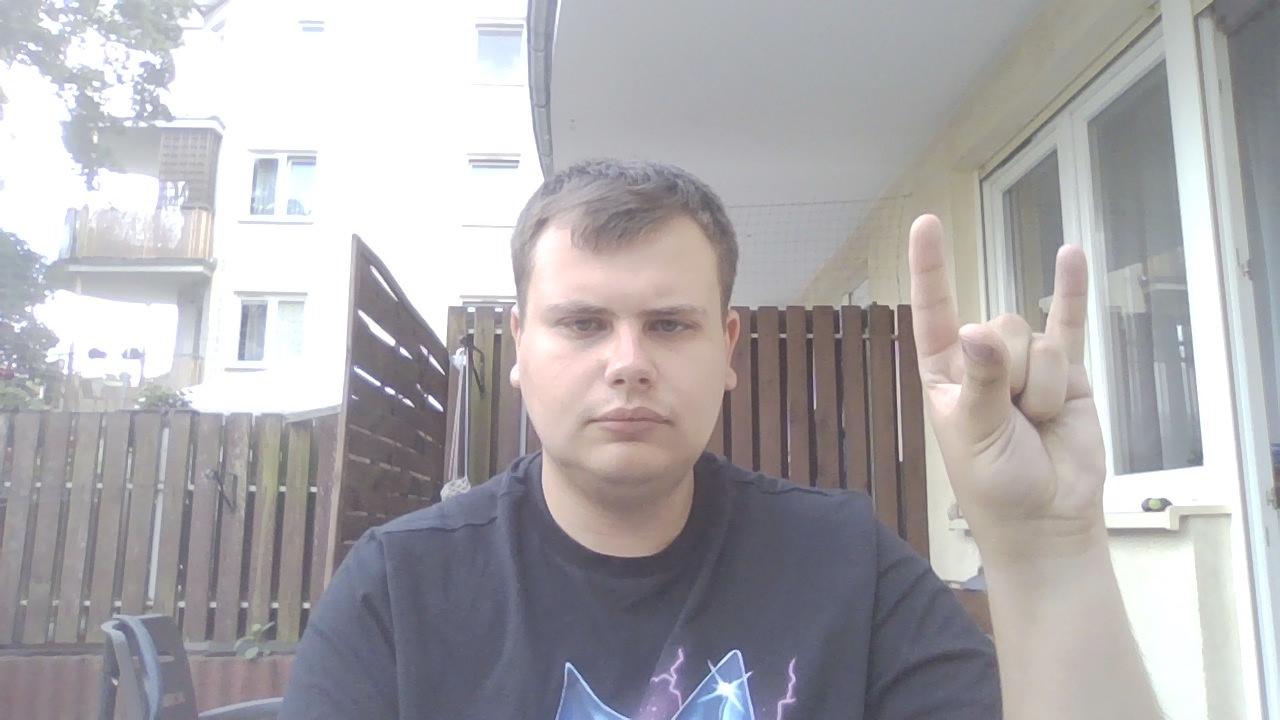

L_I_LOVE_U_HIGH_BRIGHTER.jpg


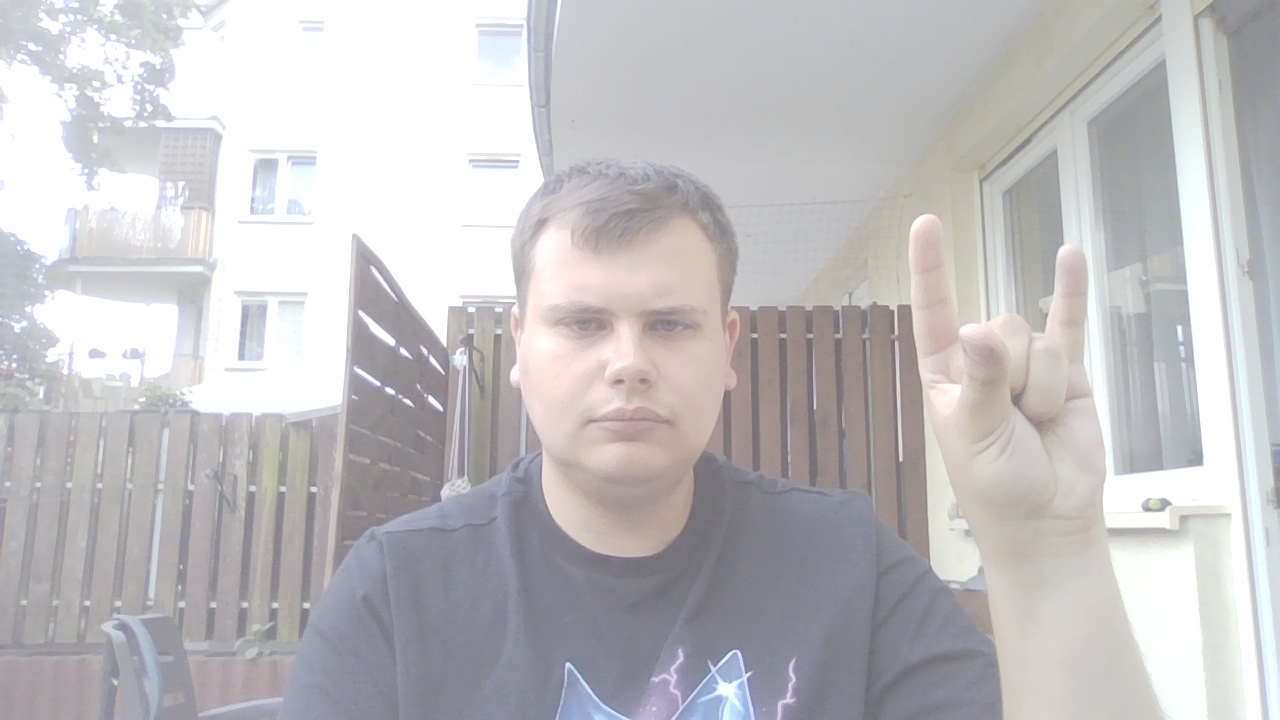

L_I_LOVE_U_LOW_DARKER.jpg


KeyboardInterrupt: ignored

In [9]:
import os
rootdir = 'drive/MyDrive/mediapipiePhotos'

for root, dirs, files in os.walk('drive/MyDrive/mediapipiePhotos'):
        for file in files:
            print(file)
            resize_and_show(os.path.abspath(os.path.join(root, file)))

## Running inference and visualizing the results

Here are the steps to run gesture recognizer using MediaPipe.

Check out the [MediaPipe documentation](https://developers.google.com/mediapipe/solutions/vision/gesture_recognizer/python) to learn more about configuration options that this solution supports.

*Note: Gesture Recognizer also returns the hand landmark it detects from the image, together with other useful information such as whether the hand(s) detected are left hand or right hand.*

In [ ]:
import mediapipe as mp

BaseOptions = mp.tasks.BaseOptions
GestureRecognizer = mp.tasks.vision.GestureRecognizer
GestureRecognizerOptions = mp.tasks.vision.GestureRecognizerOptions
VisionRunningMode = mp.tasks.vision.RunningMode

# Create a gesture recognizer instance with the video mode:
options = GestureRecognizerOptions(
    base_options=BaseOptions(model_asset_path='gesture_recognizer.task'),
    running_mode=VisionRunningMode.VIDEO)
with GestureRecognizer.create_from_options(options) as recognizer:
  video = mp.V
  recognizer.recognize

In [ ]:
# STEP 1: Import the necessary modules.
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision

# STEP 2: Create an GestureRecognizer object.
base_options = python.BaseOptions(model_asset_path='gesture_recognizer.task')
options = vision.GestureRecognizerOptions(base_options=base_options)
recognizer = vision.GestureRecognizer.create_from_options(options)

images = []
results = []
titles = []


for root, dirs, files in os.walk('drive/MyDrive/mediapipiePhotos'):
        for file in files:
            image = mp.Image.create_from_file(os.path.abspath(os.path.join(root, file)))
            # STEP 4: Recognize gestures in the input image.
            recognition_result = recognizer.recognize(image)

            # STEP 5: Process the result. In this case, visualize it.
            images.append(image)
            titles.append(file)
            try:
              top_gesture = recognition_result.gestures[0][0]
              hand_landmarks = recognition_result.hand_landmarks
              results.append((top_gesture, hand_landmarks))
            except:
              print('Classification error: '+file)
display_batch_of_images_with_gestures_and_hand_landmarks(images, results,titles)

Classification error: R_I_LOVE_U_HIGH_BRIGHTER.jpg
Classification error: R_I_LOVE_U_HIGH_DARKER.jpg
Classification error: R_I_LOVE_U_HIGH_LORENTZ.jpg
Classification error: R_I_LOVE_U_HIGH_POISSON.jpg
Classification error: R_THUMB_UP_HIGH_LORENTZ.jpg
Classification error: R_THUMB_UP_HIGH_POISSON.jpg
Classification error: L_CLOSED_FIST_HIGH_POISSON.jpg
Classification error: R_CLOSED_FIST_HIGH_POISSON.jpg
Classification error: L_OPEN_PALM_HIGH_LORENTZ.jpg
Classification error: R_OPEN_PALM_HIGH_POISSON.jpg


In [ ]:
import mediapipe as mp
import cv2
mp_drawing = mp.solutions.drawing_utils
mp_hands = mp.solutions.hands

BaseOptions = mp.tasks.BaseOptions
GestureRecognizer = mp.tasks.vision.GestureRecognizer
GestureRecognizerOptions = mp.tasks.vision.GestureRecognizerOptions
GestureRecognizerResult = mp.tasks.vision.GestureRecognizerResult
VisionRunningMode = mp.tasks.vision.RunningMode


video = cv2.VideoCapture('THUMB_UP_VID.mp4')

# Create a image segmenter instance with the live stream mode:
options = GestureRecognizerOptions(
    base_options=BaseOptions(model_asset_path='gesture_recognizer.task'),
    running_mode=VisionRunningMode.VIDEO)

timestamp = 0
with GestureRecognizer.create_from_options(options) as recognizer:
  # The recognizer is initialized. Use it here.
    while video.isOpened(): 
        # Capture frame-by-frame
        ret, frame = video.read()
#         if not ret:
#             print("Ignoring empty frame")
#             break

        timestamp += 34
        mp_image = mp.Image(image_format=mp.ImageFormat.SRGB, data=frame)
        results = recognizer.recognize_for_video(mp_image, timestamp)
        
        mp_drawing.draw_landmarks(mp_image, results.hand_landmarks,  
                                 mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4),
                                 mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
                                 )

        # 3. Left Hand
        mp_drawing.draw_landmarks(mp_image, results.hand_landmarks,
                                 mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4),
                                 mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                                 )
        

        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

video.release()
cv2.destroyAllWindows()